In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters, color
from skimage.color import rgb2gray
from PIL import Image

In [2]:
import os
import re
import pandas as pd
from skimage.io import imread

# Root folder containing AP and LA
root_dir = '/Users/krishshah/Desktop/Krish_Sky_Long_AI/resized_dataset'

data = []
pattern = r'(\d+)-([MF])-0*(\d+)Y\d*\.jpg'

for angle in ['AP', 'LA']:
    folder = os.path.join(root_dir, angle)
    count = 0
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            match = re.match(pattern, fname)
            if not match:
                print(f"Filename skipped (pattern mismatch): {fname}")
                continue
            # _, sex, age = match.groups()  # Sex not needed now
            age = int(match.group(3))
            image_path = os.path.join(folder, fname)
            try:
                image = imread(image_path)
            except Exception as e:
                print(f"Could not read image {image_path}: {e}")
                continue
            data.append({
                'filename' : fname,
                'image': image,
                'age': age
            })
            count += 1
            if count >= 300:  # Stop after 200 images
                break

# Build DataFrame with just image and age columns
df = pd.DataFrame(data, columns=['image', 'age'])
print(df.shape)
print(df.head())


(600, 2)
                                               image  age
0  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...   70
1  [[[253, 253, 253], [255, 255, 255], [245, 245,...   69
2  [[[2, 2, 2], [2, 2, 2], [1, 1, 1], [1, 1, 1], ...   52
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   11
4  [[[186, 186, 186], [177, 177, 177], [171, 171,...   56


In [3]:
df = df.sample(frac=1, random_state=41).reset_index(drop=True) # shuffles the dataframe

In [4]:
def to_grayscale(image):
    """Convert an image to grayscale."""
    if len(image.shape) == 3:  # Check if the image is RGB
        return color.rgb2gray(image)
    return image  # Already grayscale

# Image Processing Functions
def sobel_filter(image):
    """Apply Sobel filter to the image."""
    return filters.sobel(image)

def gaussian_filter(image, sigma=1): # best result so far
    """Apply Gaussian filter to the image."""
    return filters.gaussian(image, sigma=sigma)

In [5]:
#df['image'] = [gaussian_filter(image) for image in df['image']]

In [6]:
class ImageAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.loc[idx, 'image']
        age = self.df.loc[idx, 'age']

        # If img is numpy array, convert to PIL (needed for torchvision transforms)
        if img.ndim == 3 and img.shape[-1] == 3:
            # RGB numpy image
            img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            img = img.convert("L")  # or "RGB" if you want 3-channel
        elif img.ndim == 2:
            # Grayscale numpy image
            img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            img = img.convert("L")

        # Now apply your transform (resize, ToTensor, etc)
        if self.transform:
            img = self.transform(img)

        age = torch.tensor(age, dtype=torch.float32)
        return img, age

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=41)
train_df, val_df  = train_test_split(train_df, test_size=1/9, random_state=41)

In [8]:
# 2 different augmentations per training dataset

import albumentations as A

augment1 = A.Compose([
    A.Rotate(limit=12, p=1.0),
    A.GaussianBlur(blur_limit=(17, 31), p=1.0)
])

augment2 = A.Compose([
    A.Affine(translate_percent={"x": 0.08, "y": 0.08}, scale=(0.95, 1.05), rotate=0, p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.22, contrast_limit=0.22, p=1.0)
])

In [9]:
# creates and adds augmented types to the training set. 

def augment(df):
    augmented_rows = []

    for idx, row in df.iterrows():
        image = row['image']

        # Original row (label as 0.0)
        orig_row = row.copy()
        orig_row['augmentation_type'] = 0.0
        augmented_rows.append(orig_row)

        # Augmentation 1
        aug_img1 = augment1(image=image)['image']
        row_aug1 = row.copy()
        row_aug1['image'] = aug_img1
        row_aug1['augmentation_type'] = 1.0
        augmented_rows.append(row_aug1)

        # Augmentation 2
        aug_img2 = augment2(image=image)['image']
        row_aug2 = row.copy()
        row_aug2['image'] = aug_img2
        row_aug2['augmentation_type'] = 2.0
        augmented_rows.append(row_aug2)

    # Create new DataFrame from all rows
    df_augmented = pd.DataFrame(augmented_rows).reset_index(drop=True)

    return df_augmented

In [10]:
train_df = augment(train_df)

In [11]:
class EfficientNetAgeRegressorHead(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
        # Change first conv to accept grayscale
        if in_channels == 1:
            self.backbone.features[0][0] = nn.Conv2d(
                1, 32, kernel_size=3, stride=2, padding=1, bias=False
            )
        # Remove the original classifier head
        self.backbone.classifier = nn.Identity()
        # Custom regressor head
        self.fc1 = nn.Linear(1280, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.backbone(x)           # EfficientNet feature extractor
        x = F.relu(self.fc1(x))        # Your first FC layer
        x = self.fc2(x)                # Your output layer (regression)
        return x


In [12]:
class AgeRegressorCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # 64x64 -> 32x32 -> 16x16 -> 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (N, 16, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 32, 16, 16)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 64, 8, 8)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Suppose you already have train_df, val_df, test_df splits
BATCH_SIZE = 32

train_dataset = ImageAgeDataset(train_df, transform=transform)
val_dataset   = ImageAgeDataset(val_df, transform=transform)
test_dataset  = ImageAgeDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [14]:
import torch.optim as optim

torch.manual_seed(69)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetAgeRegressorHead(in_channels=1).to(device)
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import time

num_epochs = 100  # set as needed
patience = 10     # early stopping patience
best_val_mae = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses_mse = []
train_losses_mae = []
val_losses_mse = []
val_losses_mae = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    trn_loss_mse = 0.0
    trn_loss_mae = 0.0
    trn_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        y_pred = model(X_batch)
        loss_mse = criterion_mse(y_pred, y_batch)
        loss_mae = criterion_mae(y_pred, y_batch)

        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        trn_loss_mse += loss_mse.item() * X_batch.size(0)
        trn_loss_mae += loss_mae.item() * X_batch.size(0)
        trn_samples += X_batch.size(0)

    train_losses_mse.append(trn_loss_mse / trn_samples)
    train_losses_mae.append(trn_loss_mae / trn_samples)

    # Validation
    model.eval()
    val_loss_mse = 0.0
    val_loss_mae = 0.0
    val_samples = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device).unsqueeze(1)
            y_pred = model(X_val)
            loss_mse = criterion_mse(y_pred, y_val)
            loss_mae = criterion_mae(y_pred, y_val)
            val_loss_mse += loss_mse.item() * X_val.size(0)
            val_loss_mae += loss_mae.item() * X_val.size(0)
            val_samples += X_val.size(0)

    val_losses_mse.append(val_loss_mse / val_samples)
    val_losses_mae.append(val_loss_mae / val_samples)

    # Early Stopping Logic
    if val_losses_mae[-1] < best_val_mae:
        best_val_mae = val_losses_mae[-1]
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    print(f"Epoch {epoch}/{num_epochs} | "
        f"Train MSE: {train_losses_mse[-1]:.4f}, "
        f"Val MSE: {val_losses_mse[-1]:.4f} | "
        f"Train MAE: {train_losses_mae[-1]:.4f}, "
        f"Val MAE: {val_losses_mae[-1]:.4f}, "
        f"No Improve: {epochs_no_improve}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored based on lowest validation MAE.")

end_time = time.time()
print(f"Training took: {(end_time - start_time) / 60:.2f} minutes")

Epoch 0/100 | Train MSE: 942.5735, Val MSE: 232.4857 | Train MAE: 23.8592, Val MAE: 12.4718, No Improve: 0
Epoch 1/100 | Train MSE: 137.7374, Val MSE: 122.9061 | Train MAE: 9.1111, Val MAE: 8.9040, No Improve: 0
Epoch 2/100 | Train MSE: 64.2208, Val MSE: 90.7968 | Train MAE: 6.2371, Val MAE: 7.4676, No Improve: 0
Epoch 3/100 | Train MSE: 44.6288, Val MSE: 79.6271 | Train MAE: 5.3156, Val MAE: 7.0956, No Improve: 0
Epoch 4/100 | Train MSE: 31.4174, Val MSE: 93.8186 | Train MAE: 4.4381, Val MAE: 7.8205, No Improve: 1
Epoch 5/100 | Train MSE: 28.3987, Val MSE: 83.2346 | Train MAE: 4.2289, Val MAE: 7.5560, No Improve: 2
Epoch 6/100 | Train MSE: 24.6652, Val MSE: 106.3584 | Train MAE: 3.9306, Val MAE: 8.3606, No Improve: 3
Epoch 7/100 | Train MSE: 26.2438, Val MSE: 77.5069 | Train MAE: 4.0739, Val MAE: 7.2034, No Improve: 4
Epoch 8/100 | Train MSE: 22.8021, Val MSE: 81.3213 | Train MAE: 3.6961, Val MAE: 7.1490, No Improve: 5
Epoch 9/100 | Train MSE: 22.8424, Val MSE: 72.2253 | Train MAE: 3.

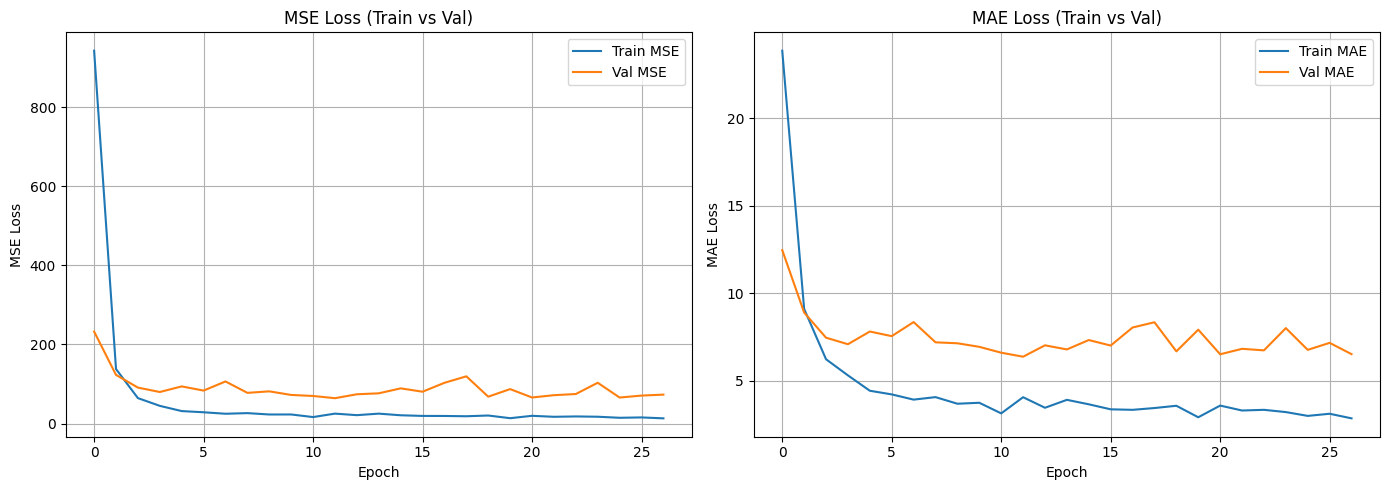

In [16]:
# --- Plotting losses ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_mse, label='Train MSE')
plt.plot(val_losses_mse, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss (Train vs Val)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses_mae, label='Train MAE')
plt.plot(val_losses_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE Loss (Train vs Val)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
within_years = 5  # or any threshold you like

model.eval()
diff = []
correct = 0
all_true_ages = []
all_pred_ages = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch).squeeze(1)  # shape: (batch,)
        true_ages = y_batch     # shape: (batch,)

        # Move to CPU for numpy ops, detach from computation graph
        pred_ages = y_pred.cpu().numpy()
        true_ages = true_ages.cpu().numpy()

        all_true_ages.extend(true_ages)
        all_pred_ages.extend(pred_ages)

        for pred_age, true_age in zip(pred_ages, true_ages):
            difference = abs(pred_age - true_age)
            diff.append(difference)
            if difference <= within_years:
                correct += 1

Number within 5 years: 29/60 (48.33%)
The mean absolute difference: 7.0791


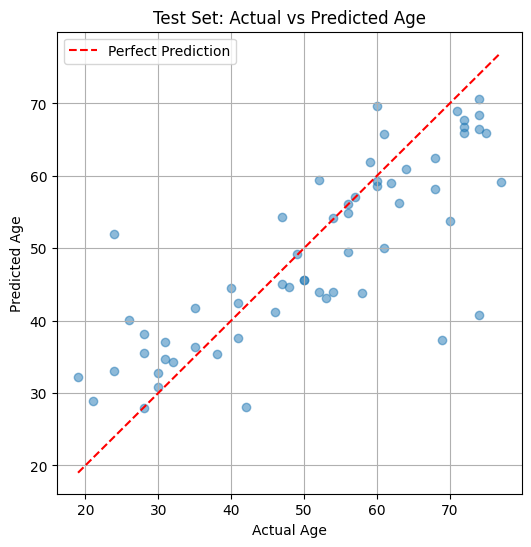

In [22]:
# Final reporting
mean_diff = sum(diff) / len(diff)
accuracy = correct / len(diff) * 100

print(f'Number within {within_years} years: {correct}/{len(diff)} ({accuracy:.2f}%)')
print(f'The mean absolute difference: {mean_diff:.4f}')

# Optional: Scatter plot of prediction vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(all_true_ages, all_pred_ages, alpha=0.5)
plt.plot([min(all_true_ages), max(all_true_ages)], [min(all_true_ages), max(all_true_ages)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Test Set: Actual vs Predicted Age')
plt.legend()
plt.grid(True)
plt.show()